In [31]:
import os
import imageio
from PIL import Image
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from DataLoading import DataLoad
from EncoderArch import Encoder
from DecoderArch import Decoder
from Loss import get_loss
from TrainerConstruct import Trainer
from datetime import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random

In [3]:
# CHANGE THE ENCODER PATH
ENCODER_PATH = 'vae_encoder_20250411_160125.pth'
DECODER_PATH = 'vae_decoder_20250411_160125.pth'

# CHANGE THE PATH IF DATA CHANGE
DATASET_PATH = "./Data/images_original"

# KEEP THE LATENT SPACE SIZE THE SAME UNLESS MODEL ARCH CHENGES
LATENT_SPACE_SIZE = 128 

# CHOOSE THE GENRE YOU ARE INTERESTED IN
class1 = "blues"
class2 = "classical"

classes = ['blues', 'classical', 'country', 'disco', 
 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [5]:
def prepare_data(DATASET_PATH):
    dx, dy = 0, 0
    dimx, dimy = 128, 128
    batch_size = 64
    
    dataload = DataLoad(DATASET_PATH)
    all_photos, all_attrs = dataload.fetch_dataset(dx, dy, dimx, dimy)
    all_photos = np.array(all_photos / 255, dtype='float32')
    
    return all_photos, all_attrs

In [39]:
def load_model(encoder_path, decoder_path):
    encoder = Encoder(LATENT_SPACE_SIZE)
    encoder.load_state_dict(torch.load(encoder_path))
    encoder.eval()

    decoder = Decoder(LATENT_SPACE_SIZE)
    decoder.load_state_dict(torch.load(decoder_path))
    decoder.eval()
    return encoder, decoder

In [9]:
def encode_images(encoder, images):
    with torch.no_grad():
        images_tensor = torch.from_numpy(images)
        images_tensor = images_tensor.permute(0, 3, 1, 2)
        mu, logvar, z = encoder(images_tensor)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return z.numpy()

In [35]:
def PlotAttributeShift(data, pic_output):
    if isinstance(pic_output, torch.Tensor):
        pic_output = pic_output.detach().cpu().numpy()
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()

    if data.shape[1] == 3:  
        data = np.transpose(data, (0, 2, 3, 1)) 
    if pic_output.shape[1] == 3:
        pic_output = np.transpose(pic_output, (0, 2, 3, 1))

    pic_output = np.clip(pic_output, 0, 1)

    sample_index = random.sample(range(1, len(data)), 16)

    fig, axs = plt.subplots(4, 8, figsize=(15, 10))
    for i in range(4):
        for j in range(4):
            axs[i, 2*j].imshow(data[sample_index[4*i+j]])
            axs[i, 2*j].axis('off')
            
            axs[i, 2*j+1].imshow(pic_output[sample_index[4*i+j]])
            axs[i, 2*j+1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [27]:
def AttributeShift(encoder_model,decoder_model,data1,data2):
    latent_codes_data1 = encode_images(encoder_model, data1)
    latent_codes_data2 = encode_images(encoder_model, data2)
    mean_code_data1 = np.mean(latent_codes_data1, axis=0)
    mean_code_data2 = np.mean(latent_codes_data2, axis=0)
    attribute_shift_vector = mean_code_data1 - mean_code_data2
    shifted_codes = latent_codes_data2 + attribute_shift_vector
    shifted_codes = torch.from_numpy(shifted_codes).float()
    
    with torch.no_grad():
        pic_output = decoder_model(shifted_codes)
    return pic_output

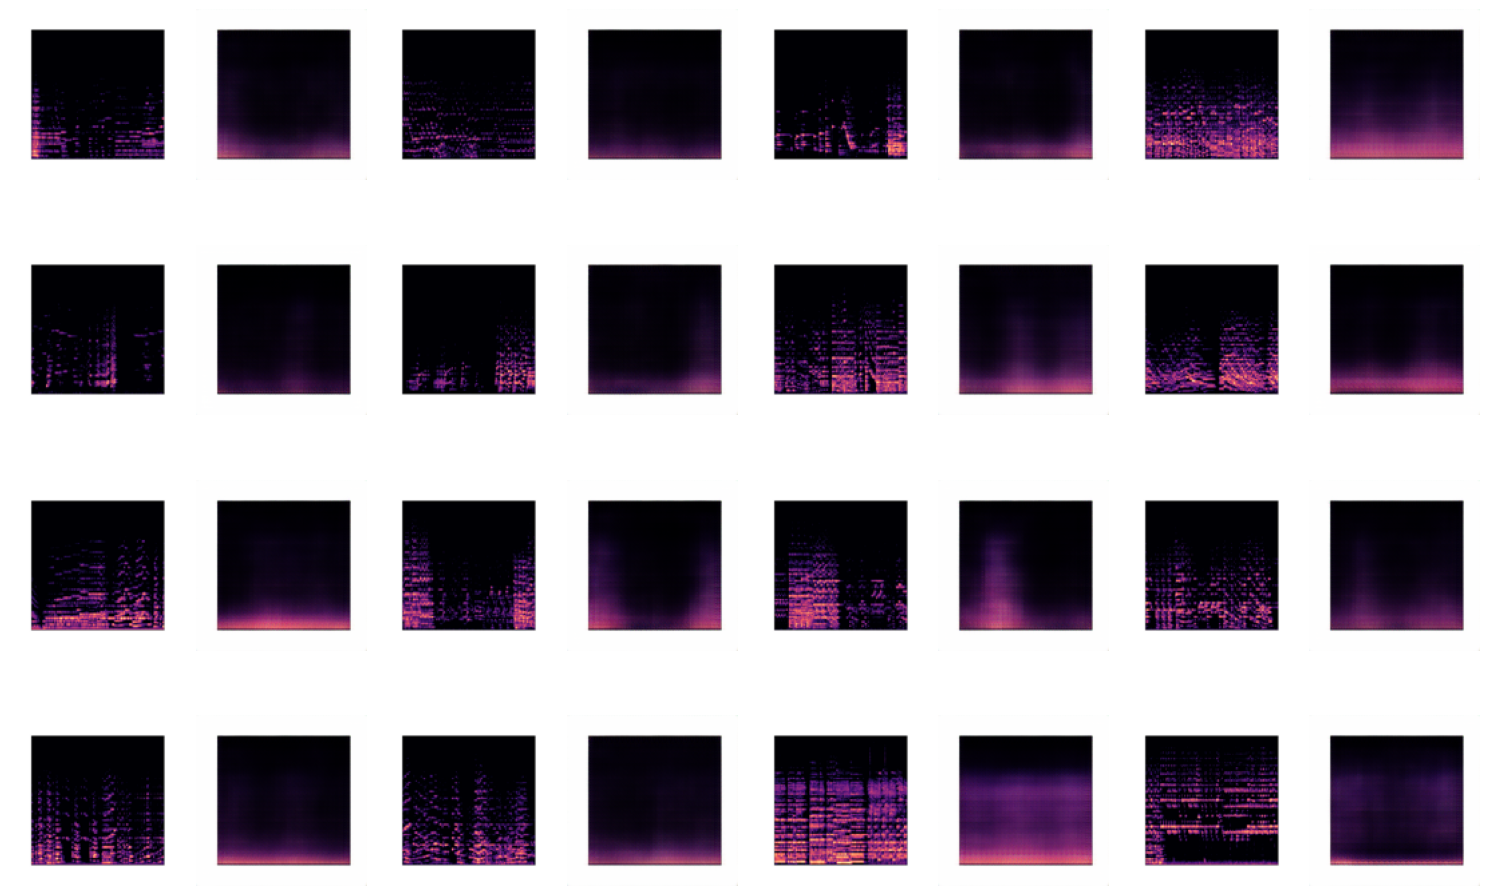

In [37]:
if __name__ == "__main__":
    all_photos, all_attrs = prepare_data(DATASET_PATH)
    encoder, decoder = load_model(ENCODER_PATH, DECODER_PATH)
    class1_index = classes.index(class1)
    class2_index = classes.index(class2)
    class1_idx = np.where(all_attrs == class1_index)
    class2_idx = np.where(all_attrs == class2_index)
    
    data1 = all_photos[class1_idx]
    data2 = all_photos[class2_idx]
    
    shifted_pics = AttributeShift(encoder, decoder, data1, data2)
    PlotAttributeShift(data2, shifted_pics)